# <center>Assignment 1 – Machine Learning</center>
### <center>Lankun Chen – Albin Lindqvist – Li Ren</center>
#### <center>Group 7</center>

In [1]:
import time
from typing import Tuple, Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import make_regression
from sklearn.linear_model import ElasticNet, Lasso, LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, train_test_split


In [2]:
red_data = pd.read_csv("winequality-red.csv", sep=";")
white_data = pd.read_csv("winequality-white.csv", sep=";")


# 2.

### Verify if the parameters obtained from the closed-form solution are the same as coeffs


Sample Size : 1000, difference between closed_form solution and coefficient : 0.
Sample Size : 1500, difference between closed_form solution and coefficient : 0.
Sample Size : 2000, difference between closed_form solution and coefficient : 0.
Sample Size : 2500, difference between closed_form solution and coefficient : 0.
Sample Size : 3000, difference between closed_form solution and coefficient : 0.
Sample Size : 3500, difference between closed_form solution and coefficient : 0.
Sample Size : 4000, difference between closed_form solution and coefficient : 0.
Sample Size : 4500, difference between closed_form solution and coefficient : 0.
Sample Size : 5000, difference between closed_form solution and coefficient : 0.
Sample Size : 5500, difference between closed_form solution and coefficient : 0.
Sample Size : 6000, difference between closed_form solution and coefficient : 0.
Sample Size : 6500, difference between closed_form solution and coefficient : 0.
Sample Size : 7000, differen

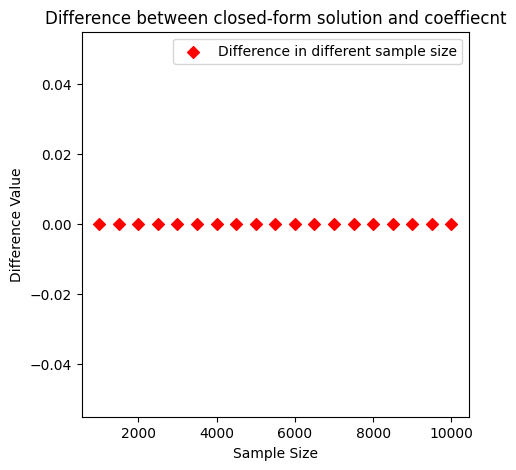

In [3]:
sample_size = np.arange(1000, 10500, 500)
diff = []

for n_samples in sample_size:
    X_i, y_i, coef_i = make_regression(n_samples=n_samples, coef=True, random_state=10)

    # Using closed-form solution method to caculate Beta.
    beta_i = np.linalg.inv(X_i.T @ X_i) @ X_i.T @ y_i

    # How many coefficents differ by more than 0.0000000001 units by using ordinary least square method.
    difference = abs(np.isclose(beta_i, coef_i, atol=1e-10).sum() - len(beta_i))
    diff.append(difference)
    print(
        f"Sample Size : {n_samples}, difference between closed_form solution and coefficient : {difference}."
    )


plt.figure(figsize=(5, 5))
plt.scatter(
    sample_size,
    diff,
    marker="D",
    color="red",
    label="Difference in different sample size",
)
plt.ylabel("Difference Value")
plt.xlabel("Sample Size")
plt.title("Difference between closed-form solution and coeffiecnt")
plt.legend()
plt.show()


As we can see above. The beta we get from closed-from solution is almost the same with coefficient.

### The drawbacks of closed-form OLS solution

Assuming that the dataset has n samples and m features, hence the $X$ is a n x m size matrix. In the step of closed-form solution, $X^TX$ will be calculated, which is a m x m size matrix. The most important thing is that the execution efficiency of the algorithm for finding $(X^TX)^{-1}$ is very low.

According to the complexity of algorithm, the matrix inversion code has cubic complexity $O(n^3)$.

Therefore, as the number of features increases, the computer will need greater performance to handle a large number of iterations.This means that when the number of features is very large (that is, when m is very large), the performance of the computer is not enough to handle such a huge calculation, and will waste more time and efficiency. Above all, the closed form solution is only suitable for processing datasets with a relatively low number of features.

We can vividly see the potential disadvantages of closed-form through the execution time of the program:


In [4]:
# Create a function which can calculate the operating time between this 2 methods


def operating_time(n_features: int) -> Tuple[float, float]:
    """A function that calculates operating time between closed form solution and other method."""
    start_1 = time.time()
    X_i, y_i, coef_i = make_regression(
        n_samples=1000, n_features=n_features, coef=True, random_state=10
    )
    end_1 = time.time()
    time_1 = end_1 - start_1  # the time make_regression runs

    start_2 = time.time()
    beta_i = np.linalg.inv(X_i.T @ X_i) @ X_i.T @ y_i
    end_2 = time.time()
    time_2 = end_2 - start_2  # the time closed-form solution runs
    return time_1, time_2


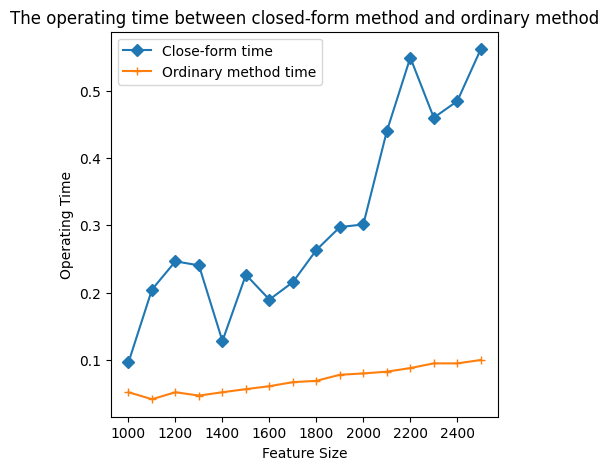

In [5]:
feature_size = np.arange(1000, 2600, 100)
closeform_time = []
make_regression_time = []

# calulate the operating time which these two methods need and plot them with increasing feature size.
for i, n_features in enumerate(feature_size):
    value_1, value_2 = operating_time(n_features=n_features)
    closeform_time.append(value_2)
    make_regression_time.append(value_1)

plt.figure(figsize=(5, 5))
plt.plot(feature_size, closeform_time, marker="D", label="Close-form time")
plt.plot(feature_size, make_regression_time, marker="+", label="Ordinary method time")
plt.xlabel("Feature Size")
plt.ylabel("Operating Time")
plt.title("The operating time between closed-form method and ordinary method")
plt.legend()
plt.show()


From this example, we can see that when the feature size continues to increase, the execution time of the closed-form solution ~~program~~_code_ increases at ~~an alarming rate~~ _a much faster rate_, and is far greater than the execution time of the ordinary method. _Thus, it is easy to draw the conclusion that the Ordinary Least-Square method is much more efficent than the closed form_

# 3.

To make life a little easier we begin by creating some supporting functions to print the different kinds of loss scores, and a function that fits and tests the model, and sends the result to the `get_all_scores` function.


In [6]:
ModelRegressors = Union[LinearRegression, Ridge, Lasso, ElasticNet]


def get_all_scores(pred: np.array, y_true: np.array, model_name: str) -> None:
    """Prints a nicely formatted table with loss from the model predictions."""
    mae = mean_absolute_error(y_true, pred)
    msq = mean_squared_error(y_true, pred)
    r2 = r2_score(y_true, pred)
    print(f"{model_name:^27}")
    print("*" * 27)
    print(f"{'Method':<19}| Result")
    print("—" * 27)
    print(f"{'R^2':<19}| {r2:.4f}")
    print(f"{'Mean Absolute Error':<19}| {mae:.4f}")
    print(f"{'Mean Squared Error':<19}| {msq:.4f}")


def fit_and_test_model(
    model: ModelRegressors,
    X_train_data: np.array,
    X_test_data: np.array,
    y_train_data: np.array,
    y_test_data: np.array,
    print_result: bool = False,
    model_name: str = "",
) -> Tuple[ModelRegressors, np.array]:
    """Function that fits the model and make a prediction, and, if wanted, prints it."""
    model.fit(X_train_data, y_train_data)
    pred = model.predict(X_test_data)
    if print_result:
        get_all_scores(pred=pred, y_true=y_test_data, model_name=model_name)
    return model, pred


In [7]:
# Get the data X_w, y_w <=> white wine dataset and X_r, y_r <=> red wine dataset.
# Dictionaries will be used to pass the data in a simple manner.
X_w_train, X_w_test, y_w_train, y_w_test = train_test_split(
    white_data.drop(["quality"], axis=1), white_data["quality"], random_state=100
)
white_data_dictionary = {
    "X_train_data": X_w_train,
    "X_test_data": X_w_test,
    "y_train_data": y_w_train,
    "y_test_data": y_w_test,
}

X_r_train, X_r_test, y_r_train, y_r_test = train_test_split(
    red_data.drop(["quality"], axis=1), red_data["quality"], random_state=100
)
red_data_dictionary = {
    "X_train_data": X_r_train,
    "X_test_data": X_r_test,
    "y_train_data": y_r_train,
    "y_test_data": y_r_test,
}


In the following code we create a function that makes us test different kinds of models, and produces relevant graphs. The function will be called twice. Firstl it will do the testing on the Red wine dataset, and then on the white wine dataset.


In [8]:
def do_exercise(type_of_wine: str = "white") -> None:
    if type_of_wine.startswith(("w", "W")):
        data_to_use = white_data_dictionary
        wine_type = "White"
    elif type_of_wine.startswith(("r", "R")):
        data_to_use = red_data_dictionary
        wine_type = "Red"
    else:
        raise ValueError

    figure, axis = plt.subplots(2, 2)

    # Ordinary Least Square
    lr = LinearRegression(n_jobs=-1)
    fit_and_test_model(
        lr, print_result=True, model_name="Ordinary Least-Squares", **data_to_use
    )

    # Ridge grid search for interval alpha in [0.0001, 100]
    parameter = {"alpha": np.logspace(-4, 2, num=100)}
    ridge_grid = GridSearchCV(
        Ridge(), param_grid=parameter, return_train_score=True, n_jobs=-1
    )
    ridge_grid.fit(data_to_use["X_train_data"], data_to_use["y_train_data"])
    ridge = Ridge(**ridge_grid.best_params_)
    fit_and_test_model(
        ridge,
        print_result=True,
        model_name=f"Ridge - alpha={ridge_grid.best_params_['alpha']:.4f}",
        **data_to_use,
    )
    _ = pd.DataFrame(ridge_grid.cv_results_).plot(
        x="param_alpha",
        y=["mean_test_score", "mean_train_score"],
        logx=True,
        ax=axis[0, 0],
    )
    axis[0, 0].set_title("Ridge Score w.r.t alpha")

    # Lasso grid serach with same interval as ridge
    lasso_grid = GridSearchCV(
        Lasso(), param_grid=parameter, return_train_score=True, n_jobs=-1
    )
    lasso_grid.fit(data_to_use["X_train_data"], data_to_use["y_train_data"])
    lasso = Lasso(**lasso_grid.best_params_)
    fit_and_test_model(
        lasso,
        print_result=True,
        model_name=f"Lasso - alpha={lasso_grid.best_params_['alpha']:.4f}",
        **data_to_use,
    )
    _ = pd.DataFrame(lasso_grid.cv_results_).plot(
        x="param_alpha",
        y=["mean_test_score", "mean_train_score"],
        logx=True,
        ax=axis[0, 1],
    )
    axis[0, 1].set_title("Lasso Scores w.r.t. alpha")

    # Elastic Net grid search with same alpha, and l1_ration in interval [0,1]
    parameter["l1_ratio"] = np.linspace(1e-5, 1, num=25)
    elastic_grid = GridSearchCV(
        ElasticNet(), param_grid=parameter, return_train_score=True, n_jobs=-1
    )
    elastic_grid.fit(data_to_use["X_train_data"], data_to_use["y_train_data"])
    elastic = ElasticNet(**elastic_grid.best_params_)
    fit_and_test_model(
        elastic,
        print_result=True,
        model_name=f"ElasticNet - alpha={elastic_grid.best_params_['alpha']:.4f} - l1_ratio={elastic_grid.best_params_['l1_ratio']:.4f}",
        **data_to_use,
    )
    grid_results = pd.DataFrame(elastic_grid.cv_results_)[
        ["param_alpha", "param_l1_ratio", "mean_test_score", "mean_train_score"]
    ].to_numpy()

    # Normal line plot will not work with two variables, we will use contour plot
    countor = axis[1, 0].tricontour(
        grid_results[:, 0].astype(float),
        grid_results[:, 1].astype(float),
        grid_results[:, 2].astype(float),
        levels=300,
        cmap="Greens",
    )
    axis[1, 0].set_xscale("log")
    # axis[1, 0].set_yscale("log")
    axis[1, 0].set_title("ElasticNet Score Contour Plot of Test Score")
    figure.colorbar(countor)
    countor = axis[1, 1].tricontour(
        grid_results[:, 0].astype(float),
        grid_results[:, 1].astype(float),
        grid_results[:, 3].astype(float),
        levels=300,
        cmap="Greens",
    )
    axis[1, 1].set_xscale("log")
    # axis[1,1].set_yscale('log')
    axis[1, 1].set_title("ElasticNet Score Contour Plot of Train Score")
    figure.colorbar(countor)
    axis[1, 0].set_xlabel("param alpha")
    axis[1, 1].set_xlabel("param alpha")
    axis[1, 0].set_ylabel("param l1_ratio")
    axis[1, 1].set_ylabel("param l1_ratio")
    figure.set_size_inches(20, 10)
    figure.suptitle(f"Grid Search Curves for {wine_type} wine dataset", fontsize=20)


  Ordinary Least-Squares   
***************************
Method             | Result
———————————————————————————
R^2                | 0.3293
Mean Absolute Error| 0.5001
Mean Squared Error | 0.4237
   Ridge - alpha=0.8697    
***************************
Method             | Result
———————————————————————————
R^2                | 0.3254
Mean Absolute Error| 0.5009
Mean Squared Error | 0.4262
   Lasso - alpha=0.0005    
***************************
Method             | Result
———————————————————————————
R^2                | 0.3260
Mean Absolute Error| 0.5006
Mean Squared Error | 0.4258
ElasticNet - alpha=0.0009 - l1_ratio=0.0000
***************************
Method             | Result
———————————————————————————
R^2                | 0.3245
Mean Absolute Error| 0.5013
Mean Squared Error | 0.4268


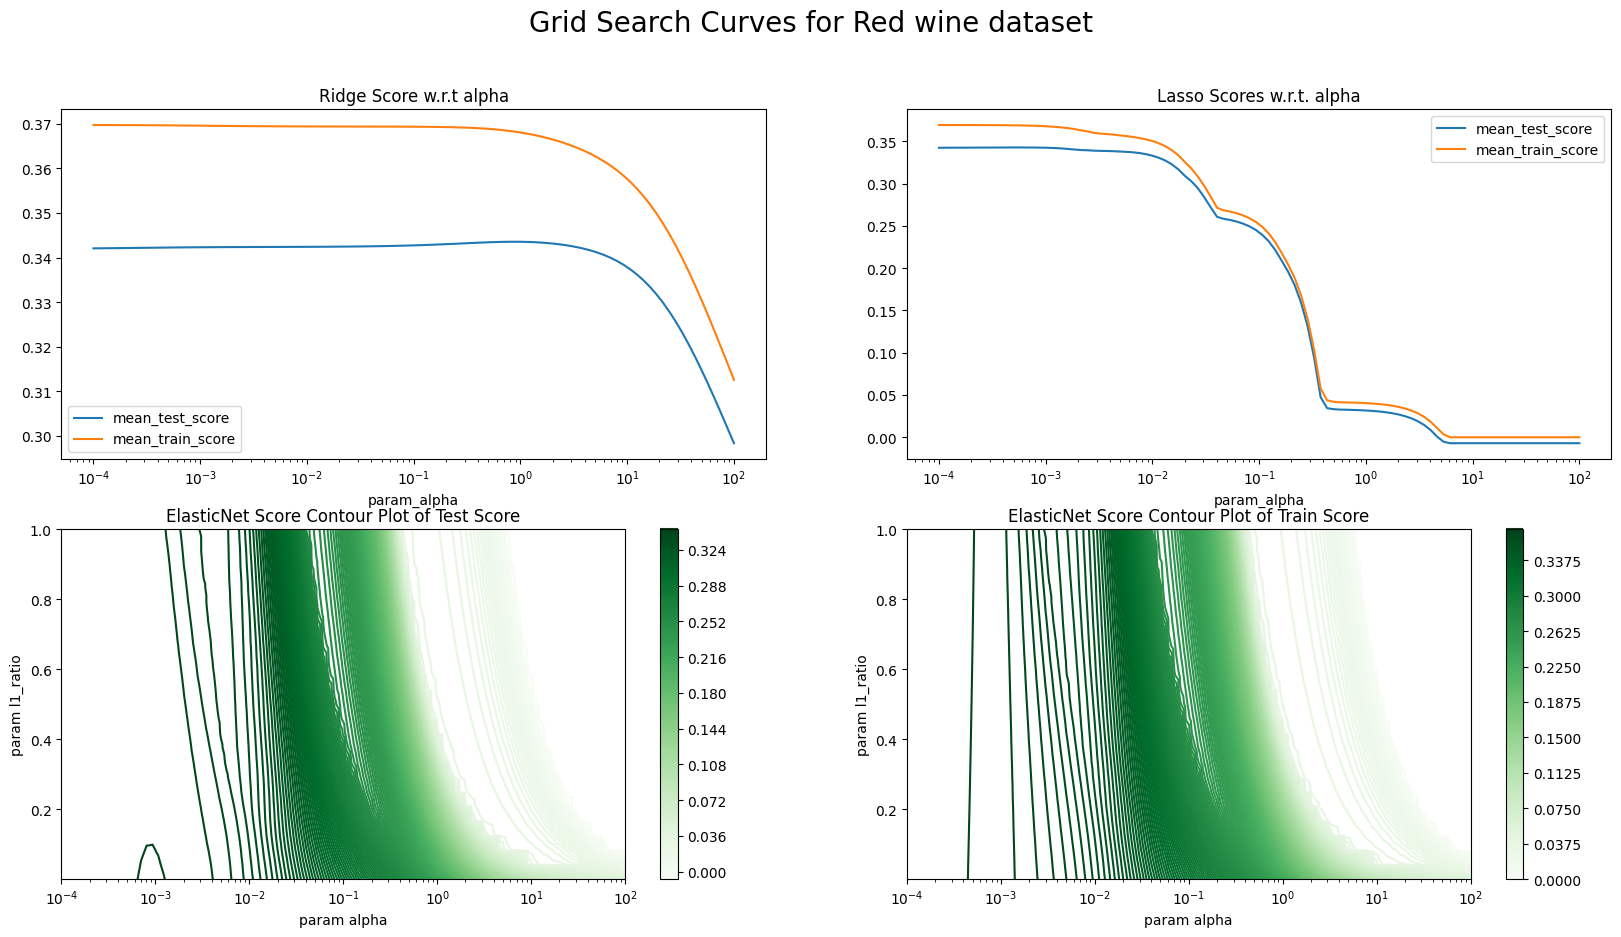

In [9]:
do_exercise("red")


## Analysis Red Wine Dataset

Looking at the initial results for the optimal hyperparameter(s) found via grid search it is clear that no improvement is made for adding regularisation. Looking at the Ridge score (L2 regularisation) curve there is a "bump" around $\alpha \approx 1$, which can be seen in the results, where the optimal $\alpha = 0.8697$ is displayed. As $\alpha$ increases it can be noted that the spread between the test and train score decreases. This implies that it does less overfitting, however, it should also be noted that the overall score decreases as well. Showing that the model performs rather badly for those values. Further, it should be considered that there is almost no difference in test scores, especially in the interval $\alpha\in[10^{-1},10]$.

Taking a look at the Lasso score (L1 regularisation) curve a similar picture arises. Although the model performance is much worse when $\alpha > 10^{-2}$, and consistently decreases for larger $\alpha$. Looking at this curve it can, as the results also show, be concluded that $\alpha < 10^{-3}$. It appears that also here regularisation does not help increase test scores. For example compare $R^2$ results from OLS $0.3293$ and Lasso $0.3260$

Lastly, the ElasticNet score (L1 and L2 regularisation) contour plot shows how the two hyperparameters `l1_ratio` and $\alpha$ affect the test/train score. It clearly looks like $\alpha$ is the most important hyperparameter for this dataset, given that the contours are principally vertical. There is, just as for L1 and L2 separate regularisation a tendency to choose very small $\alpha$. The largest improvement in test and train score is found in the interval $\alpha \in (10^{-2},1]$ as the contours are the closest in this interval. Indeed it shows in the result that a low `l1_ratio` and $\alpha$ gives the best score.

In conclusion, it should be mentioned that the best-performing model is still OLS. Although the difference is, not surprisingly, small, since $\alpha$ is small in all the models, and thus almost no regularisation takes place.


  Ordinary Least-Squares   
***************************
Method             | Result
———————————————————————————
R^2                | 0.2539
Mean Absolute Error| 0.5807
Mean Squared Error | 0.5755
   Ridge - alpha=0.0005    
***************************
Method             | Result
———————————————————————————
R^2                | 0.2540
Mean Absolute Error| 0.5804
Mean Squared Error | 0.5755
   Lasso - alpha=0.0001    
***************************
Method             | Result
———————————————————————————
R^2                | 0.2488
Mean Absolute Error| 0.5826
Mean Squared Error | 0.5795
ElasticNet - alpha=0.0001 - l1_ratio=0.0000
***************************
Method             | Result
———————————————————————————
R^2                | 0.2487
Mean Absolute Error| 0.5826
Mean Squared Error | 0.5796


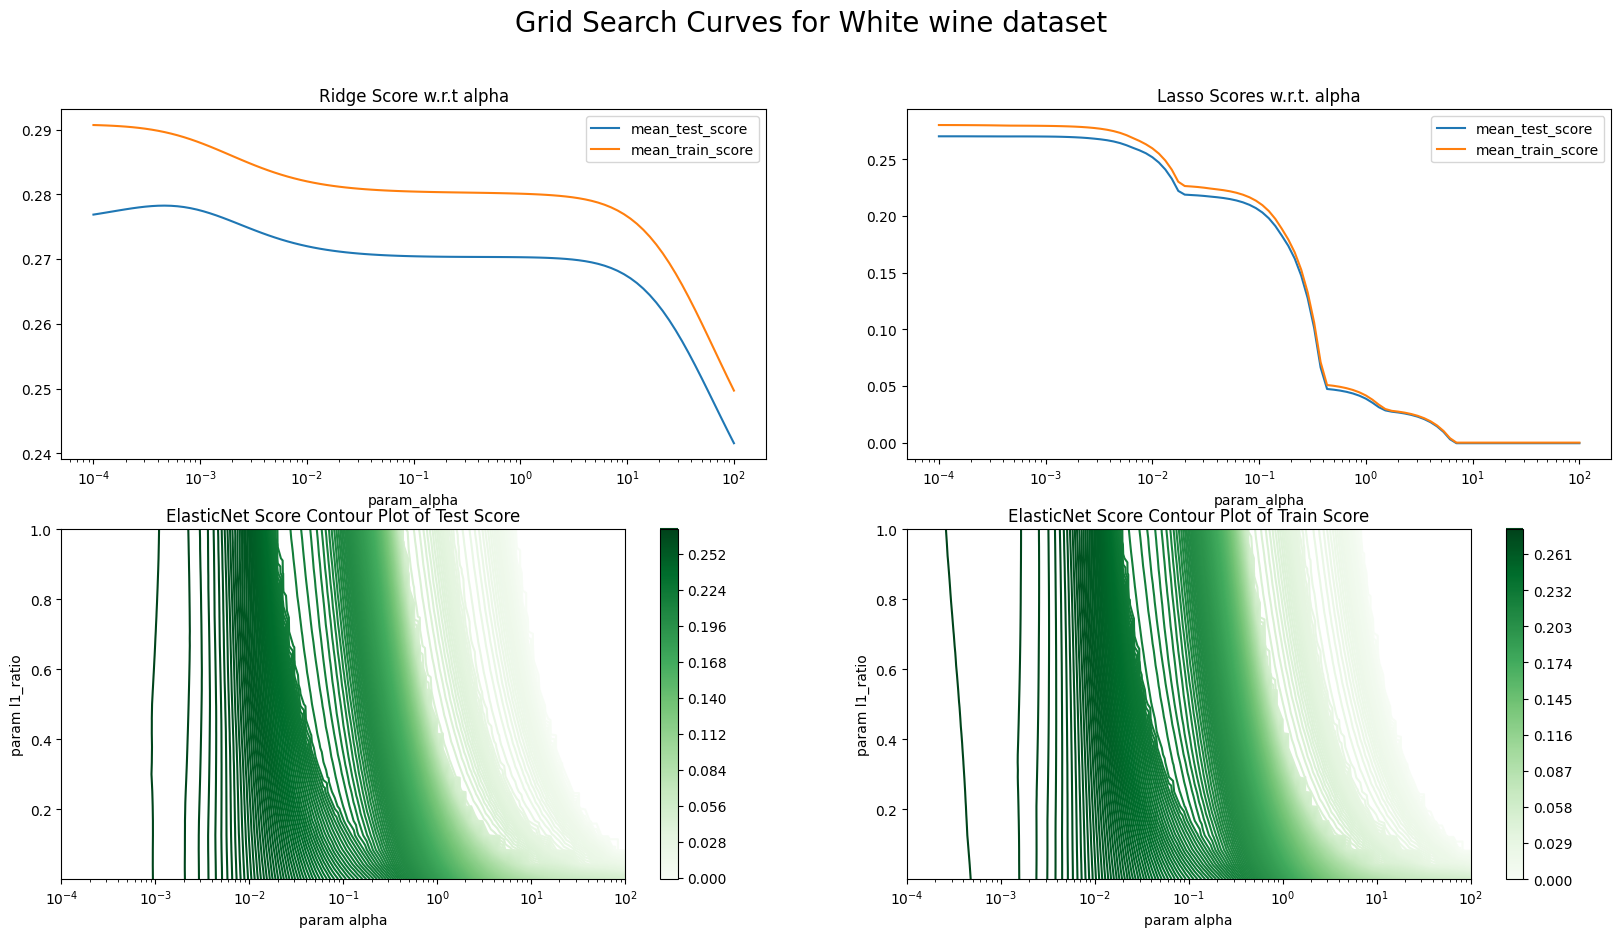

In [10]:
do_exercise("white")


## Analysis White Wine Dataset

For this dataset, the best performing one is the one with L2 regularisation. However, the difference is negligible (or the same) and most likely due to random luck. In other words, regularisation does, as was the case for the red dataset, very little to improve performance.

This dataset does show a different Ridge score curve compared to the red wine dataset. It appears that the regularisation is weakening the model even earlier. Nonetheless, the real drop-off point is still when $\alpha \approx 10$. The Lasso score curve exhibits a similar form as it did on the red wine dataset.

The major difference, except for the lower score on the white dataset, is the ElasticNet score plots. Looking at the bottom of the graph, it appears that the contours are somewhat tilted. A similar phenomenon existed on the white dataset but was not as apparent. This behavior of the plot indicates that for the same `l1_ratio` a different alpha is better. It is the most obvious for a low `l1_ratio` i.e $<0.2$. This is most likely because of the result we saw with the L2 regularisation having its optimum $\alpha$ a bit away from $0$.
